# Lab 2 : Classification

### Group 3 - Members:

_Tai Chowdhury_<br>
_Apurv Mittal_<br>
_Ravi Sivaraman_<br>
_Seemant Srivastava_<br>


## Data Preparation Part 1

As discussed in *Lab 1*, we have acquired the Australian Weather dataset from Kaggle portal. It contains 10 years of weather data collected from many locations across Australia. These are daily weather observations. There are 145,459 observations with 23 attributes in the original dataset. 

We have chosen `RainTomorrow` (categorical) and `Rainfall` (continuous) as predictor variables. RainTomorrow is a categorical attribute which indicates whether it is going to rain tomorrow - yes or no. Rainfall is a continuous attribute that measures amount of rainfall each of the particular locations have received (in mm). Using our models, we will be able to design an algorithm where the bureau can help to predict rainfall for different regions in Australia.

In this Lab 2 assignment, we have measured the accuracy and effectiveness of our model for categorical variable RainTomorrow by using 10-fold cross validation against the confusion matrix measurements like: Precision, Recall and Accuracy. We have explored the methods of logistic regression and support vector machine (SVM) models on our dataset. 

We have used `scikit-learn` packages for our exploration. We ran logistic regression models with all the available solvers in the `scikit-learn` package and compare the effictiveness and accuracy of the model to predict `RainfallTomorrow`. We also measured the duration of model run from each models to compare model performance and efficiency as well.
 
To get started, we will start with loading all the necessary packages for our analysis. We will start our analysis with `df_impute` which is the imputed dataframe from our last explanatory data analysis Lab 1 project. Using this dataframe will ensure data consistency for all the labs going forward.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import stats
import warnings
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [2]:
#Ignore Warnings on final

warnings.filterwarnings('ignore')

In [44]:
#Original Data
df = pd.read_csv("weatherAUS.csv")

In [45]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12/1/08,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,12/2/08,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12/3/08,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,12/4/08,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,12/5/08,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


#### Dropping columns

We decided to drop `Date` and `Location` as they are not pertinent to our analysis in this Lab 2 project.

In [46]:
df = df.drop(['Date', 'Location'], axis = 1)
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No



We imputed data in EDA project by substituting the missing and `NaN` values. We are reusing the imputed data from EDA (Lab1) project.
Here is the link to the EDA for reference:

https://nbviewer.jupyter.org/github/ravisiv/AussieWeatherEDA/blob/c0ba412cb75da21eba386ea9ea39f645ad6af1d0/DS7331_Lab1_Group3_Ravi_Taifur_Seemant_Apurv_Submission.ipynb


In [58]:
# Read the Imputed Australia weather data
df_impute = pd.read_csv("weatherAUS_imputed.csv")
df_impute.shape

(140787, 21)

The imputed data doesn't include any null or missing values. Also, we have dropped the columns like: Date of observation and City Name.

In [59]:
df_impute_num = df_impute.columns[df_impute.dtypes == 'float64']
df_impute_cat=df_impute.columns[df_impute.dtypes == 'object']
print("Numeric Variables:", df_impute_num)
print("Categorical Variables:", df_impute_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')


Before continuing further, we need to check which variables are numeric and which are not. As the models expect numerical variables. We will filter and identify non-numeric variables.

`WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday` and `RainTomorrow`are not numeric. Here `RainTomorrow` is our response variable. we handle the other variables with hot-one-encoding later in the flow.

In [60]:
#Keep the original data
df_model = df_impute.copy()

Creating a new DataFrame `df_model` for modeling to avoid any changes to the original dataset `df_impute`.

In [61]:
# Create a new variable to Identify if it RainToday

df_model["IsRainToday"] = df_impute['RainToday']

# Replacing No with 0 and Yes with 1.

df_model['IsRainToday'].replace({'No': 0, 'Yes': 1},inplace = True)


Assigning `0` to No values and `1` to Yes values in `RainToday` (Changed to `IsRainToday`)

In [10]:
print("df_impute", df_impute.shape)
print("df_model", df_model.shape)


df_impute (140787, 21)
df_model (140787, 22)


In [11]:
# Printing the values to check if the data looks good

df_model.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,IsRainToday
0,13.4,22.9,0.6,6.032209,8.890686,W,44.0,W,WNW,20.0,...,22.0,1007.7,1007.1,8.000000,3.684394,16.9,21.8,No,No,0
1,7.4,25.1,0.0,6.032209,8.890686,WNW,44.0,NNW,WSW,4.0,...,25.0,1010.6,1007.8,3.635105,3.684394,17.2,24.3,No,No,0
2,12.9,25.7,0.0,6.032209,8.890686,WSW,46.0,W,WSW,19.0,...,30.0,1007.6,1008.7,3.635105,2.000000,21.0,23.2,No,No,0
3,9.2,28.0,0.0,6.032209,8.890686,NE,24.0,SE,E,11.0,...,16.0,1017.6,1012.8,3.635105,3.684394,18.1,26.5,No,No,0
4,17.5,32.3,1.0,6.032209,8.890686,W,41.0,ENE,NW,7.0,...,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,0


### One-hot encoding

Before we create our models, we need to format our attributes. We are converting `RainToday` and `RainTomorrow` into numeric variables to `0` and `1`. We also decided to go ahead with one-hot-encoding `WindGustDir`, `WindDir9am`, and `WindDir3pm` attributes based on the direction of the wind. 

In [62]:
# perform one-hot encoding using dummies

gust_df = pd.get_dummies(df_model.WindGustDir,prefix='GustDir', drop_first= True)
wind3pm_df = pd.get_dummies(df_model.WindDir3pm,prefix='Wind3pm', drop_first= True)
wind9am_df = pd.get_dummies(df_model.WindDir9am,prefix='Wind9am' , drop_first= True)
df_model = pd.concat((df_model,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe


We decided to do one-hot-encoding using dummies function as machine learning algorithms and models requires numerical values for both input and output attributes.

Since the dummies function creates a variable for each unique value, we are dropping the first variable to avoid multicollinearity among the variables as the value for the last variable can be interpreted from the values for other variables created as part of one-hot encoding.



In [63]:
# Drop categorical columns

df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

After conversions, we are removing these categorical attributes to avoid duplicates as we have those data in numerical format. We are added the newly formatted attributes and rest of the continuous attributes into a new dataframe - df_model. We will use the new dataframe for modeling.

Reference: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [14]:
#Check if Yes is replaced as 1

print("Are there 1's and 0's in the RainToday column?", 
      (df_model['IsRainToday'].sum() > 0) and (df_model['IsRainToday'].sum() < len(df_model['IsRainToday'])))

#Non zero output means there is a mixture of 1's and 0's


Are there 1's and 0's in the RainToday column? True


Checking if the data imputation happened accurately.

In [15]:
df_model_num = df_model.columns[df_model.dtypes != 'object' ]
df_model_cat=df_model.columns[df_model.dtypes == 'object']
print("Numeric Variables:", df_model_num)
print("Categorical Variables:", df_model_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'IsRainToday', 'GustDir_ENE', 'GustDir_ESE',
       'GustDir_N', 'GustDir_NE', 'GustDir_NNE', 'GustDir_NNW', 'GustDir_NW',
       'GustDir_S', 'GustDir_SE', 'GustDir_SSE', 'GustDir_SSW', 'GustDir_SW',
       'GustDir_W', 'GustDir_WNW', 'GustDir_WSW', 'Wind3pm_ENE', 'Wind3pm_ESE',
       'Wind3pm_N', 'Wind3pm_NE', 'Wind3pm_NNE', 'Wind3pm_NNW', 'Wind3pm_NW',
       'Wind3pm_S', 'Wind3pm_SE', 'Wind3pm_SSE', 'Wind3pm_SSW', 'Wind3pm_SW',
       'Wind3pm_W', 'Wind3pm_WNW', 'Wind3pm_WSW', 'Wind9am_ENE', 'Wind9am_ESE',
       'Wind9am_N', 'Wind9am_NE', 'Wind9am_NNE', 'Wind9am_NNW', 'Wind9am_NW',
       'Wind9am_S', 'Wind9am_SE', 'Wind9am_SSE', 'Wind9am_SSW', 'Wind9am_SW',
       'Wind9am_W', 'Wind9am_WNW', 'Wind9am_WSW'],
      dtype='

Check if all the numerical variables are accurately created and if we still have any non-numeric data.

Assigning the `RainTomorrow` as our response variable (y) and all other variables include one-hot-encoded values as X.

In [16]:
X=df_model[df_model_num]
y = df_model.RainTomorrow
print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (140787, 62)
target shape: (140787,)


#### Response Variables
For our dataset, we are using two response variables:

1. `RainTomorrow` - Categorical variable for classification
2. `Rainfall` - Continuous variable for regression

We are going to introduce additional variable in our dataset:

`RainfallAmount` - Categorical variable for rainfall classification. We have covered this in more detail in another section.

#### Scaling

We will be using scaled data for our models. We have used the scaling feature as part of our customed function for running our classifications and regression models. We will discuss more in details in the modeling sections.

#### New Feature

We are adding a new classification feature called `RainfallAmount` which has four values - `None` (0), `Low`(1), `Moderate`(2) and `High`(3). We are creating this feature from `Rainfall` feature from our dataframe. The data is numerical due to the requirement of the execution of the classification models.

In [64]:
# New Feature - RainfallAmount

def rain_classifier(row):
    if row["Rainfall"] > 30:
        return 3
    elif row["Rainfall"] > 10 and row["Rainfall"] < 30:
        return 2
    elif row["Rainfall"] > 1 and row["Rainfall"] < 10:
        return 1
    else:
        return 0

df_model["RainfallAmount"] = df_impute.apply(rain_classifier, axis=1)


In [65]:
df_model.RainfallAmount.unique()

array([0, 1, 2, 3])

#### Down-sampling

Due to large amount of data and multiple models being evaluated in this project, our computers are not able to handle the load and have been crashing which is leading to increased processing time and repetitive work. To avoid this situation we have made few changes in our models.

1. Down Sample the data based on the `RainToday`
2. Reduced the various combinations of hyper tuning parameters to preserve the memory and processing power.
3. Reduced the number of additional models we were running as part of exceptional work, like: XGBOOST, Linear SVC.

In [55]:
#Downsampling before we run our models 
df_model_copy = df_model[df_model.IsRainToday  == np.random.choice(df_model['IsRainToday'].unique())].reset_index(drop=True)
df_model = df_model_copy.copy()


### Data Distribution

Check if the data distribution is balanced or not for the response variable `RainTomorrow`.

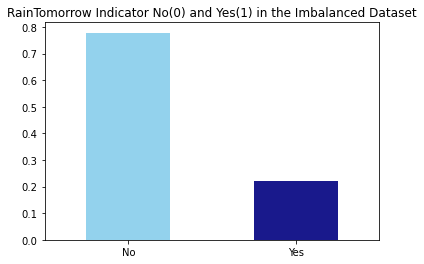

In [38]:
       

df_impute['RainTomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()


As expected, we see the data for `RainTomorrow` is imbalanced. Majority of the data is for `No` rain vs. `Yes` for `RainTomorrow`.

We can observe that the presence of `0` and `1` is almost in the `78:22` ratio. We will be cognizant of the fact that our model may be not very effective if we don't solve for imbalance. We will discuss and adjust for this imbalance in our analysis.

## Data Preparation Part 2

In [66]:
df_model_copy = df_model.copy()

In [21]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109332 entries, 0 to 109331
Data columns (total 64 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   MinTemp         109332 non-null  float64
 1   MaxTemp         109332 non-null  float64
 2   Rainfall        109332 non-null  float64
 3   Evaporation     109332 non-null  float64
 4   Sunshine        109332 non-null  float64
 5   WindGustSpeed   109332 non-null  float64
 6   WindSpeed9am    109332 non-null  float64
 7   WindSpeed3pm    109332 non-null  float64
 8   Humidity9am     109332 non-null  float64
 9   Humidity3pm     109332 non-null  float64
 10  Pressure9am     109332 non-null  float64
 11  Pressure3pm     109332 non-null  float64
 12  Cloud9am        109332 non-null  float64
 13  Cloud3pm        109332 non-null  float64
 14  Temp9am         109332 non-null  float64
 15  Temp3pm         109332 non-null  float64
 16  RainTomorrow    109332 non-null  object 
 17  IsRainToda

The above dataframe has float64, object, int64, and uint8 data formats. Float64, int64, and uint8 are all numerical data type. Object is a string data type. 

#### Response Variables

We have three response features in our current dataframe. They are `RainTomorrow`, `Rainfall`, and `RainfallAmount`. `RainTomorrow` and `RainfallAmount` are for our classification models. `Rainfall` is used for continuous regression models. Our primary focus is on `RainTomorrow` and `RainfallAmount` as the prediction for `Rainfall` is not very accurate. We will present the accuracy of this feature in later section. 

In [22]:
df_model.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,109332.0,11.991795,6.492771,-8.5,7.3,11.900000,16.700000,33.9
MaxTemp,109332.0,24.108916,7.050355,-2.1,18.9,23.700000,29.100000,48.1
Rainfall,109332.0,0.075187,0.199058,0.0,0.0,0.000000,0.000000,1.0
Evaporation,109332.0,5.888859,3.232216,0.0,4.6,6.032209,6.032209,86.2
Sunshine,109332.0,8.309311,2.757027,0.0,7.5,8.890686,9.500000,14.5
...,...,...,...,...,...,...,...,...
Wind9am_SW,109332.0,0.048723,0.215290,0.0,0.0,0.000000,0.000000,1.0
Wind9am_W,109332.0,0.050086,0.218123,0.0,0.0,0.000000,0.000000,1.0
Wind9am_WNW,109332.0,0.045879,0.209223,0.0,0.0,0.000000,0.000000,1.0
Wind9am_WSW,109332.0,0.039668,0.195179,0.0,0.0,0.000000,0.000000,1.0


We ran summary statistics on the final model dataset. We can see the various satistical summary of the features. We see some large variations in the dataset like Evaportaion ranges from 0 to 145, Rainfall varies from 0 mm to 371 mm. Which are huge variation but as determined during `EDA` (Lab 1) those are not outliers and for our analysis we will consider then as valid observations.

## Modeling And Evaluation 1

For our model performance measurement, we will use precision and accuracy. We are using those because we found the accuracies are very close across all the models. So we want to select on more performance metric for model evaluation.

`Accuracy` — is a ratio of correctly predicted observation to the total observations. It is a very important aspect to define the success of a model but just the measurement on its own can be deceiving if the observations are not equal for each class. In such cases we might be predicting accurately for one particular class with large observation and may not do very well for other classes.

`Precision` — is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision = TP/TP+FP

`Weighted Average` — can be calculated on various output variables of the classification report like Precision, Recall, f1-score. As the name suggests it gives the weighted average of the parameter based on the number of observations or values for each class.

`Macro Average` — similar to weighted average, macro average can also be calculated on various output variables of the classification report like Precision, Recall, f1-score. However, the similarity ends here as unlike weighted average, we don't use weights based on the number of observations, rather equal weights are given to each class to calcualte the value. This tells us if the Precision is as good if the dataset was balanced.

`RMSE` - The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss. Lower the RMSE, better is the accuracy of the model.This is used for regression models.

References:

https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

#### Macro Avg vs Weight Avg Precision comparisons

As we can't pick the models just from Accuracy as the accuracy can be varying partcularly for unbalanced data (like there could be High True Positives but low true negatives ans still have high accuracy), we further our analysis by plotting the difference between the Macro Avg precision and Weighted Avg precision for all the models.

`DiffMacro/WeightedNone` — takes the Macro Average and Weighted Average of Precision from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the Precision values based on how the data is split.

`DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a balanced data.

The smaller the difference between Weight Avg and Macro Avg, the model is closer to real world and also consistent.

## Modeling And Evaluation 2

As per MiniLab,  we are going to use `Stratified` because our response feature (`RainTomorrow` and `RainfallAmount`) data is disproportionaly distributed. 

For `RainTomorrow`, response - `No` is very high compare to response - `Yes`. 

For `RainfallAmount`, the response - `None` is very high compare to `Low`, `Moderate`, and `High`.  

To rectify this issue, we are going to use `StratifiedSplit` for cross validation. Then we are going to use `10-fold` cross validation to improve our model accuracies. We have compare the performances between shuffle and stratified cross validated models in our MiniLab project. A snippet from MiniLab for reference below:

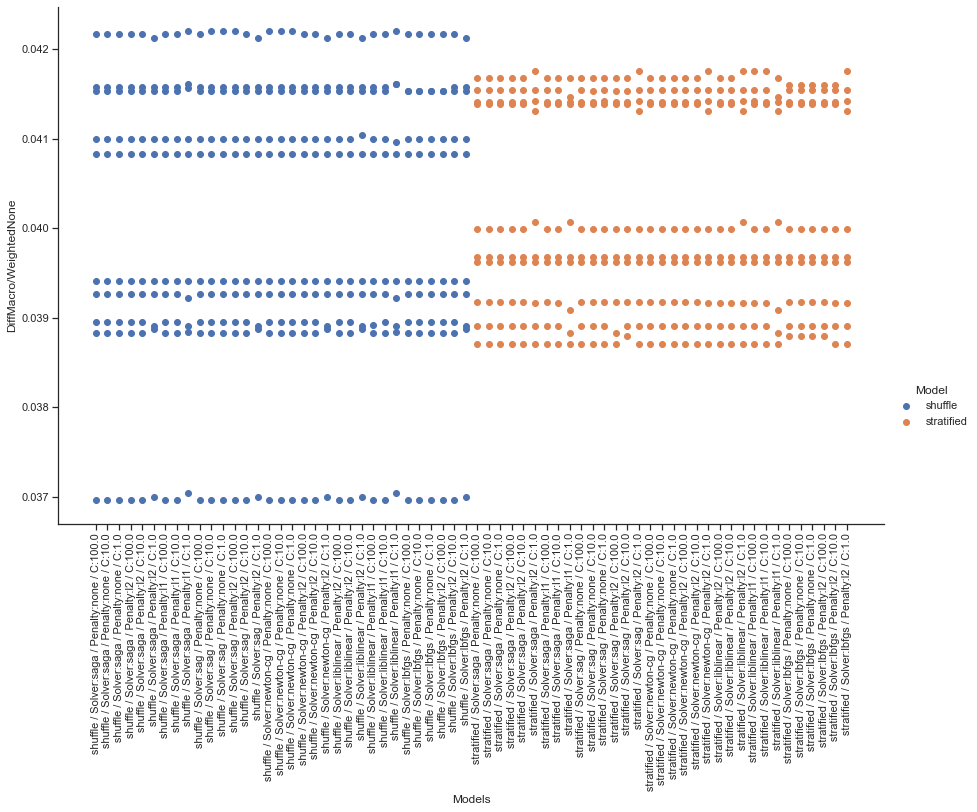

### Macro Avg vs Weight Avg Precision comparisons
__*As discussed in MiniLab*__ we did our analysis by plotting the difference between the `Macro Avg` precision and `Weighted Avg` precision for all the models. 

  `DiffMacro/WeightedNone` — takes the `Macro Average` and `Weighted Average` of `Precision` from the classification matrix and calculates the difference. The reason to calculate the difference is to check how much variation is in the `Precision` values based on how the data is split. 
  
  `DiffMacro/WeightedBalanced` — same as above this variable calculates the difference between Macro and Weighted Average of Precision of a `balanced` data.
  
The smaller the difference between `Weight Avg` and `Macro Avg`, the model is closer to real world and also consistent.  

Also, plotted the models classified into `Shuffle` and `Stratified` against `DiffMacro/WeightedNone` of precision (difference between Macro and Weighted Average of Precision of non-balanced data).
From the above plot, we notice that the difference between Macro Average of Precision and Weighted Average of Precision varies as below:

Balanced Data - `0.091` to `0.097`

Non-Balanced Data - `0.037` to `0.042`

There are two major takeaways from the above plots. 

1. The `StratifiedKFolds` data sees lower variation compared to `ShuffleSplit`.

2. Its evident that the difference between Macro Average of Precision and Weighted Average of Precision varies a lot more for `balanced` data compared to `non-balanced` data. 

Since, lower variation is desired to get more stable and consistent model. We decide to go ahead with `Stratified` and non-balanced data. In our model we have hypertuned `shuffle` as `True` for `StratifiedKFolds` as well. Also, we know `StratifiedKFolds` works well with non-balanced data.

__With above points in mind, we will continue with `Stratified` and `non-balanced` data models.__

## Modeling And Evaluation 3

The following models are the continuous regression and classification models:

### Linear Regression Model
In Linear Regression Model, the dependent variable (`Rainfall`) is dependent of independent variables (the other 16 features). This is an instance of multiple linear regression, which means, the independent variable is dependent of multiple features.

Linear Regression works with continous variables and categorical variables doesn't translate well. To make categorical variables, we used One-hot encoding to convert them to numerical vectors. The downside of it, it may introduce multi-collineriaty, but we can minimize by taking only the important features.
There are multiple ways of doing Linear Regression, LASSO, Ridge and simple linear regression. We create models of all types and get the best model that has least RMSE values.

The function below builds linear regression models:

1. `Ordinary Least squares`

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

2. `LASSO`

Linear Model trained with L1 prior as regularizer (aka the Lasso)
The optimization objective for Lasso is:
(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

3. `Elastic Net`

Procedure identical to LASSO however the penalty is different.  Elastic net uses a combination of both the LASSO penalty as well as the RIDGE regression penalty.The elastic net method reduces the limitations of the LASSO method which uses penalty as :
Lamda1 x |Slope|.
Lasso falls short in accuracy/prediction with large number of variables but a small sample size. Also, for highly correlated variables, LASSO select one variable from a group and ignore the others.
The elastic net adds a quadratic slope to the penalty same as Ridge Regression. Where in ridge regression we just use the quadratic term, in Elastic Net we use both terms for penalty as below:
Lambda1 x |Slope| + Lambda2 x (Slope)2

We create models of these and then store them in a dataframe. We then compare the RMSE of these models, and find which model has lowest RMSE and take as the best model of Regression.

 #### References for definitions
 1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 2. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
 3. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


### Grid Search Param for Linear Regression Models

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import ElasticNet


model_stats_rainfall = {}

def create_models_continous(df, iterations):

    X = None
    y = None
    if "Rainfall" in df:
        y = df["Rainfall"].values # get the labels we want
        del df["Rainfall"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    random_state = 123
    njobs = -1
    
    models = ["LinearRegression", "Lasso", "Elasticnet"]
    
    for model in models:
        start_time = timer()
        clf = None
        if model == "LinearRegression":
            clf = LinearRegression(n_jobs=njobs)
        elif model == "Lasso":
            clf = Lasso(alpha=0.05)
        elif model == "Elasticnet":    
            clf = ElasticNet(random_state=123)
    
        cv_ret = cross_validate(clf, X, y, cv=10, scoring="neg_root_mean_squared_error", n_jobs=-1 , return_estimator=True)
        end_time = timer()
        elapsed_time = end_time - start_time
        print(clf.__class__.__name__," rmse are\n", cv_ret['test_score'], '\ntook ', elapsed_time, "seconds.\n")
        
        model_stats_rainfall[clf.__class__.__name__] = [cv_ret, elapsed_time]
         

In [24]:
from sklearn.model_selection import StratifiedKFold


df_model = df_model_copy.copy()
del df_model["RainTomorrow"]

cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=123)
create_models_continous(df=df_model, iterations=cv)



LinearRegression  rmse are
 [-0.16955783 -0.20311014 -0.18510879 -0.18868588 -0.19364569 -0.21529807
 -0.19595118 -0.18222366 -0.18861764 -0.1592113 ] 
took  2.4645329159999996 seconds.

Lasso  rmse are
 [-0.17151751 -0.20607475 -0.18714533 -0.19114545 -0.19673578 -0.21980814
 -0.20030786 -0.1840779  -0.19229419 -0.15704477] 
took  0.9306950829999998 seconds.

ElasticNet  rmse are
 [-0.17382243 -0.20852261 -0.18925797 -0.19232242 -0.2004137  -0.22639346
 -0.20506379 -0.18787734 -0.19664654 -0.15683248] 
took  0.7325062500000001 seconds.



### Classification Models

In this, we create classification models for two response variables:

   1. `RainTomorrow`, that has binary classification (`Yes` = `1`, `No` = `0`).
    
   2. `RainfallAmount`, this is multiclass, has variables `None` (`0`), `Low` (`1`), `Moderate` (`2`), and `High` (`3`).

First, we are running models for `RainTomorrow`. 

We build the following models:

    1. Random Forest Classifier
    2. KNN Classifier
    3. Gaussian Naive Bayes Classifier
    4. Linear classifiers with stochastic gradient descent
    5. Logistic Regression Classifier
    
    
   ### Random Forest Classifier
   
   A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.
   
   
   Random forest is collection of decision trees where each set of trees have different set of hyper parameters, trained on different subsets of data, and create prediction. Using the model, we can visualize each tree and notice which independent features are used for prediction value computation (‘RainTomorrow’ = Yes/No or `Rainfall` values ).
   
   For our model, using `RandomForestClassifier` for classification and `RandomForestRegressor` for regression, we have created our model. 
   
   We have set the number of trees parameter to `100`. 
   
   `n_job`’ parameter indicates the number of jobs the model runs in parallel. In our case, we have set it to -1 which indicates the computation will be dispatched to all the CPUs.
   
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
   
   Definitions are from the following documentation.
   ##### Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
   

### KNN

We used the `K-Nearest Neighbors` non-parametric method for our model. 

KNN suffers from the curse of dimensionality due to a large dimensional data set. If the data set is small, KNN works well with smaller set of variables but as the numbers of variables increase, as in case in our model, the dataset size should also increase exponentially to get good prediction. KNN is not considered to be the best approach when we have large number of variables. However, the large number of variables in our dataset is due to One-Hot encoding and not necessarily are different variables. So, we don’t consider we need to do dimensionality reduction for our dataset and continued with KNN with existing dataset.

Another challenge with KNN is to identify the best possible value of K to reduce the noise as well keep the predictability high. It a trade-off between bias and variance. Small value of K typically provides lower bias but higher variance.

We ran KNN for various values of K between 1 and 9 and identified at `8` we are getting the best accuracy. 

We decided to complete our analysis for KNN at `K=8`.

### Logistic Regression
Logistic regression model is used to examine relationship between independent variable(s) and dependent variable `RainTomorrow`.
The Logistic Regression model uses various hyper tuning parameters to create a model. 

   1. `Model Type`
   2. `Class Weight`
   3. `Solver`
   4. `C`
   5. `Penalty`
   6. `Iterations`

In `MiniLab` project we ran a function runs for different values of Solver, C, Penalty and used 10 iterations.

##### Model Type

   1. `Shuffle`
   2. `Stratified`

`ShuffleSplit` — is similar to `Cross Validation` where we can specify the percentage of split for train and test data. However, in regular cross-validation, the data is not split randomly, so, it is good to shuffle the targets before applying the `cross-validation`.

`Stratified` — CV technique is very useful with unbalanced dataset. As discussed above our dataset is not balanced and rightly so, we don't expect it to rain and no-rain days to be equal in Australia. The data is expected to be unbalanced and expected to be such in future as well. So using stratified sampling techniques gives us the ability to preserve the proportion of the Rain days vs non-rain days in our dataset. We can be confident that the Train and Test split data is not leaving out important information like entire dataset is of `No` rain days which will give highly inaccurate output eventhough the accuracy might be maintained. 
In `Stratified` sampling, the data is k-1 split in favor of Train vs Test data.

We have established earlier that for our models we are moving ahead with StratifiedKFold CV.

References: 
https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d

https://mclguide.readthedocs.io/en/latest/sklearn/cv.html

##### Solver Options

Scikit-learn comes with five different solver options. Each solver minimize the cost function. Here are the five options:

`newton-cg` — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.

`lbfgs` — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets.

`liblinear` — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It performs pretty well with high dimensionality. It does have a number of drawbacks. It can get stuck, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest.

`sag` — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.

`saga` — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.
Reference for above definitions: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

##### Penalty
Used to specify the norm used in the penalization. The `newton-cg`’, `sag` and `lbfgs` solvers support only `l2` penalties. `elasticnet` is only supported by the `saga` solver. If `none` (not supported by the `liblinear` solver), no regularization is applied.

`L1` or `Lasso` — (`LASSO` is Least Absolute Shrinkage and Selection Operator) uses a penalized least squares approach that squeezes the regression coefficients to 0 when the penalty is large. The algorithm starts with a large penalty and gradually relaxes the penalty to allow for a single variable to be added into the model (the coefficient is no longer `0`). `LASSO` uses `L1` method.

`L2` or `Ridge` — adds a penalty equal to the square of the magnitude of coefficients. `L2` will not yield sparse models and all coefficients are shrunk by the same factor (not eliminated). Ridge regression and SVMs use this method.

`elasticnet` — Procedure identical to `LASSO` however the penalty is different. `elasticnet` uses a combination of both the `LASSO` penalty as well as the `RIDGE` regression penalty. It combine both `L1` & `L2` methods.

`none` — No penalty
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
Reference for Penalty definitions: https://www.statisticshowto.com/regularization/

##### C

`C` is cost, which we run with `1.0`, `10.0` and `100.0` for each combination of Solver and Penalty.
If the solver doesn't support the penalty, those are skipped.

As discussed earlier we ran various different combinations of above parameters in `MiniLab` and came to the conclusion that following combination gives the best model for Logistic Regression for our dataset.

`Model` - Stratified

`Solver` - Saga

`C` - 100

`Penalty` - None

### Naïve Bayes

`Naïve Bayes` are set of supervised learning algorithms where naïve assumption of conditional independence between every pair of features given the values of class variable. For our classification models, we have chosen Gaussian Naïve Bayes that follows Gaussian normal distributes and support continuous values in features. It creates probability values for response features. 

In our case, it creates the probability values for `Yes` and `No` for `RainTomorrow`. We have not set any specification for this modeling technique.


https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso
from timeit import default_timer as timer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

def create_models_classification(name, model, df, response_feature,iterations, target_names):
    start_time = timer()
    X = None
    y = None
    if response_feature in df:
        y = df[response_feature].values # get the labels we want
        del df[response_feature] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    random_state = 123
    njobs = -1
    scoring_metric = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
    
    cv = StratifiedKFold(n_splits=iterations,shuffle=True, random_state=random_state)
    
    cv_ret = cross_validate(model, X, y, cv=iterations, n_jobs=4, scoring=scoring_metric, return_estimator=True)

    best_estimator = cv_ret['estimator'][0]
    #This is the best estimator, now we are building the model with entire data
    
    y_hat = best_estimator.predict(X)
    conf_mat = confusion_matrix(y,y_hat)
    fpr = 0
    tpr = 0
    threshold = 0
    class_report = None
    if (len(target_names) == 2):
        y_01 = np.where(y =="Yes", 1, [0])
        y_hat_01 = np.where(y_hat =="Yes", 1, [0])
        fpr, tpr, threshold = metrics.roc_curve(y_01, y_hat_01) 
    
        class_report = classification_report(y, y_hat, target_names, output_dict=False)
    
    
    end_time = timer()
    elapsed_time = end_time - start_time
    accuracy = cv_ret['test_acc']
    
    
    print(name," accuracies are\n", accuracy, '\ntook ', elapsed_time, "seconds.")
    
    return [best_estimator, accuracy, elapsed_time, conf_mat,fpr, tpr,class_report]

In [26]:
a = ['no','yes']
print(len(a))

2


### KNN find the best K

In [27]:
# For KNN: 
df_model["RainTomorrow"] = df_impute["RainTomorrow"]
df_model["RainTomorrow"] = df_model["RainTomorrow"].map(dict(Yes=1, No=0))
y= df_model["RainTomorrow"].values
del df_model["RainTomorrow"]
X = df_model.values


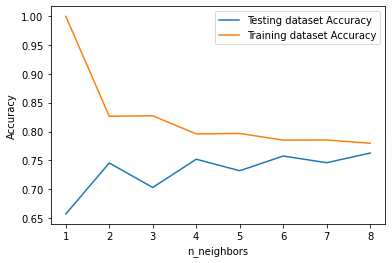

In [28]:
#Knn (model run):

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
  
  
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=123)
  
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
      
    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

max_accuracy = max_value = max(test_accuracy)

best_k = np.argmax(test_accuracy) + 1


#Reference for KNN: https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

In [29]:
print(max_accuracy)
print(best_k)

0.7627017880824988
8


The best K for our KNN model is 8. 

### Grid Search Param for Classification Models


In [39]:
param_sgd = {
    "loss" : ["hinge", "log"],
    "alpha" : [0.01, 0.1],
    "penalty" : ["l2", "none"],
}

param_GNB = {'var_smoothing': np.logspace(0,-9, num=100)}

param_rf = { 
    'n_estimators': [100, 150],
    'max_features': ['auto', 'sqrt', 'log2']
}

k_range = [best_k]
param_knn = dict(n_neighbors=k_range)

param_svc = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

param_xgboost = {
            'min_child_weight': np.arange(1, 5, 0.5).tolist(),
        }

param_logistic = {'C': [100], 'solver': ['saga'], 'penalty':['none'], 'class_weight':['balanced']}

params_grid = [param_GNB,param_sgd,param_rf, param_logistic ]


In [31]:
# The following are the list of models and the parameters 

from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


column_names = df_model.columns


#we took the best logistic regression from the mini-lab
models = [
        KNeighborsClassifier(n_neighbors=best_k),
        GaussianNB(), 
        SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,max_iter=5,tol=None, n_jobs=-1, random_state=123),
        RandomForestClassifier(n_jobs=-1, random_state=123),
        LogisticRegression(n_jobs=-1, random_state=123)
     ]

    
model_stats_raintomorrow = {}
for index, model in enumerate(models):
    df_model = df_model_copy.copy()
    #Delete Rainfall Amount (as this is a classification value of Rainfall)
    if "RainfallAmount" in df_model:
        del df_model["RainfallAmount"]
        
    clf = GridSearchCV(estimator=model, param_grid=params_grid[index],n_jobs=-1)
    stats = create_models_classification(name=model.__class__.__name__,model=clf,df=df_model,
                                         response_feature="RainTomorrow", iterations=10,
                                        target_names=['No','Yes'])
    model_stats_raintomorrow[model.__class__.__name__] = stats

KNeighborsClassifier  accuracies are
 [0.89409182 0.9002195  0.87432544 0.87953901 0.87688649 0.85264795
 0.86618494 0.89563706 0.87569743 0.8938992 ] 
took  3395.2731127499997 seconds.
GaussianNB  accuracies are
 [0.87552588 0.87195903 0.85648953 0.85712979 0.7829507  0.8148724
 0.86060551 0.88585018 0.86691667 0.88685631] 
took  268.81890487500004 seconds.
SGDClassifier  accuracies are
 [0.88421438 0.88238522 0.81221988 0.85429434 0.87487423 0.86673374
 0.85228208 0.85109302 0.85813592 0.87953901] 
took  23.755625583999972 seconds.
RandomForestClassifier  accuracies are
 [0.96460582 0.96817267 0.91100338 0.98865819 0.92280252 0.92417452
 0.91768042 0.93615659 0.93981524 0.94868746] 
took  828.1228675829998 seconds.
LogisticRegression  accuracies are
 [0.91732211 0.86656301 0.80234153 0.88923443 0.77929205 0.77874325
 0.81715906 0.87030092 0.87917315 0.90496661] 
took  95.1499972089996 seconds.


### Models for RainfallAmount

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

models = [
    GaussianNB(), 
    SGDClassifier(n_jobs=-1, random_state=123),
    RandomForestClassifier(n_jobs=-1, random_state=123),
    LogisticRegression(n_jobs=-1, random_state=123)
]

model_stats_rainfallamount = {}

df_model_ra = df_model_copy.sample(n=30000, random_state=123)


for index, model in enumerate(models):
    df_model = df_model_ra.copy()
    if "RainTomorrow" in df_model:
        del df_model['RainTomorrow']

    if "IsRainToday" in df_model:        
        del df_model['IsRainToday']

    #RainfallAmount is a classification of Rainfall, having Rainfall will give model the predicting value, 
    #so remove Rainfall 
    if "Rainfall" in df_model:   
        del df_model['Rainfall']
   
    clf = GridSearchCV(estimator=model, param_grid=params_grid[index],n_jobs=-1)
    stats = create_models_classification(name=model.__class__.__name__,model=clf,df=df_model,
                                         response_feature="RainfallAmount",
                                         iterations=10,
                                         target_names=['None', 'Low', 'Moderate', 'High']
                                        )
    model_stats_rainfallamount[model.__class__.__name__] = stats

GaussianNB  accuracies are
 [0.782      0.78566667 0.78533333 0.786      0.78333333 0.79333333
 0.77466667 0.79066667 0.784      0.78933333] 
took  36.994176125001104 seconds.
SGDClassifier  accuracies are
 [0.79433333 0.75433333 0.78333333 0.722      0.803      0.792
 0.669      0.793      0.50033333 0.786     ] 
took  609.3598770000008 seconds.
RandomForestClassifier  accuracies are
 [0.86033333 0.86266667 0.86366667 0.87       0.873      0.871
 0.86466667 0.86666667 0.864      0.86933333] 
took  206.41138024999964 seconds.
LogisticRegression  accuracies are
 [0.72966667 0.69       0.679      0.49433333 0.658      0.72833333
 0.619      0.75866667 0.71       0.77166667] 
took  44.37968379099948 seconds.


## Modeling And Evaluation 4

### Visualization of Models

#### Random Forest

The below decision trees are one of the 100 of trees in our random forest models. The tree is essentially a series of questions designed to assign a classification. There are three types of leaves in the tree. The top leap is the root node which we can traverse to the next set of rows which are decision nodes. The last node is the leaf node which does not split. These leaf nodes are where classes are assigned by majority vote.

We have printed only the partial tree for easy visualization.

Reference: https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952

#### Random Forest Decision Tree for RainTomorrow

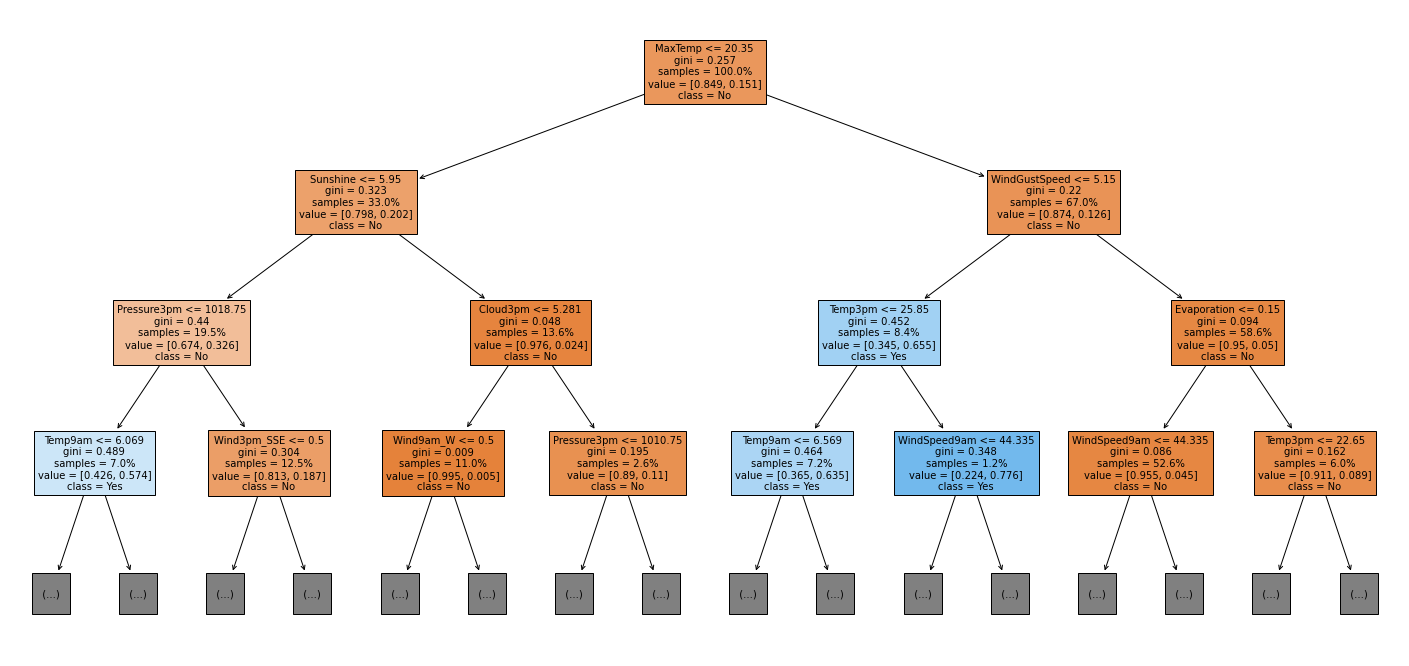

In [69]:
estimator_rf = model_stats_raintomorrow['RandomForestClassifier'][0].best_estimator_[0]

#Decision tree diagram for the first index (first tree):
from sklearn import tree
plt.figure(figsize = (25,12))
tplt = tree.plot_tree(estimator_rf, proportion = True, fontsize=10,max_depth=3,class_names = ['No', 'Yes'], filled = True, feature_names = column_names)
plt.show()

#### Random Forest Decision Tree for RainfallAmount

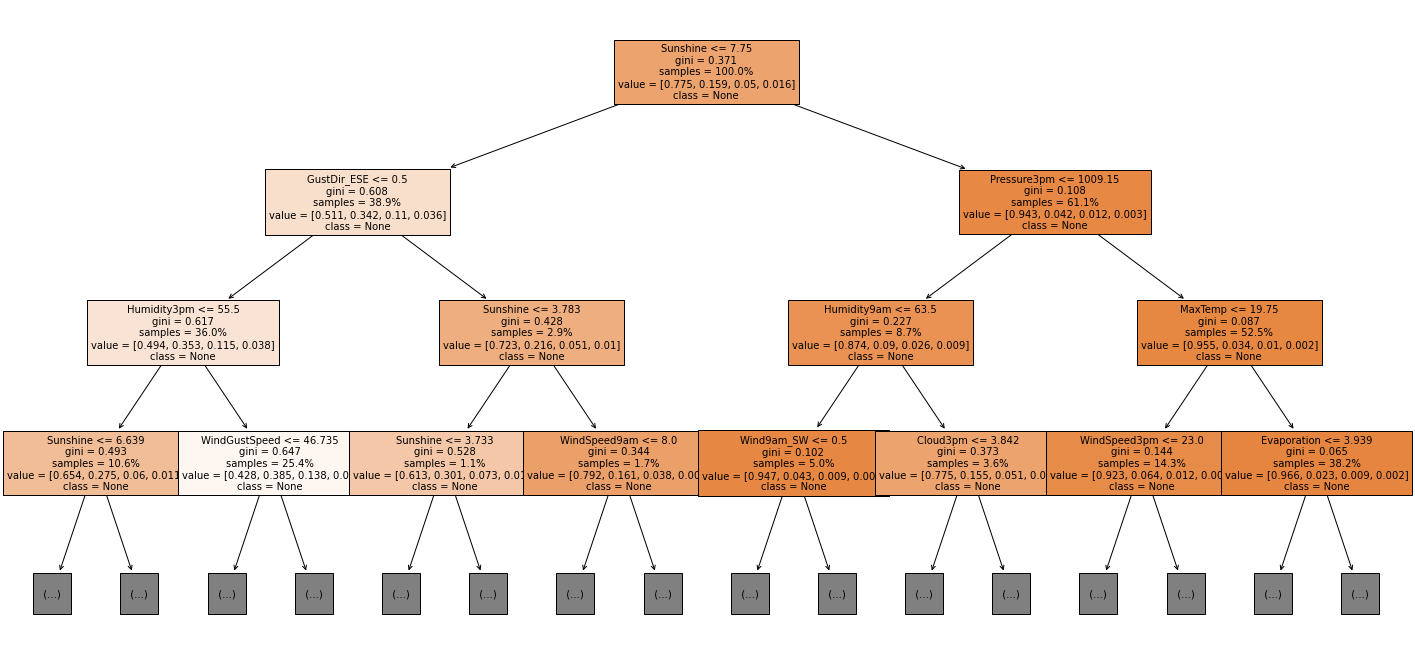

In [70]:
estimator_rf = model_stats_rainfallamount['RandomForestClassifier'][0].best_estimator_[0]

#Decision tree diagram for the first index (first tree):
from sklearn import tree
plt.figure(figsize = (25,12))
tplt = tree.plot_tree(estimator_rf, proportion = True, fontsize=10,max_depth=3,
                      class_names = ['None', 'Low', 'Moderate', 'High'], filled = True, feature_names = column_names)
plt.show()

#### ROC Curves

`AUC` - `ROC` curve is a performance measurement for the classification problems at various threshold settings. 

`ROC` is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the `AUC`, the better the model is at predicting `0`s as `0`s and `1`s as `1`s. 

The ROC curve is created by plotting the `True Positive Rate` (`TPR`) against the `False Positive Rate` (`FPR`).

`ROC` curves plot 2 quantities from the confusion matrices

`Sensitivity` (Ability to correctly predict when an event occurs)

`Specificity` (False Positives)

If a model is doing very well, then most of the predicted probabilities will be close to `0` or `1`

###### Reference: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

#### RainTomorrow Statistics

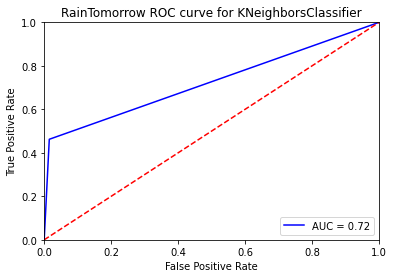

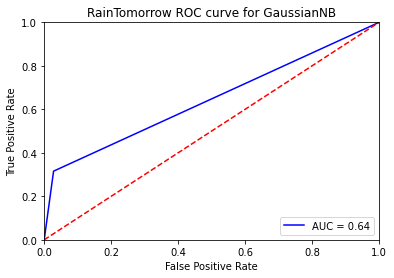

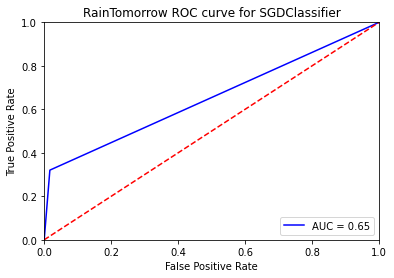

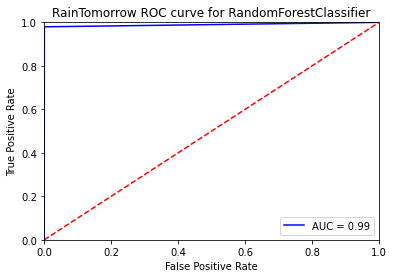

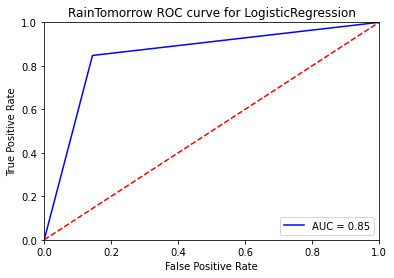

In [71]:

for key in model_stats_raintomorrow:
    fpr = model_stats_raintomorrow[key][4]
    tpr = model_stats_raintomorrow[key][5]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("RainTomorrow ROC curve for " + key)
    plt.show()

From the above AUC plots, we can see the Random Forest and Logistic Regression are the best models for `RainTomorrow` classification.

#### Confusion Matrix

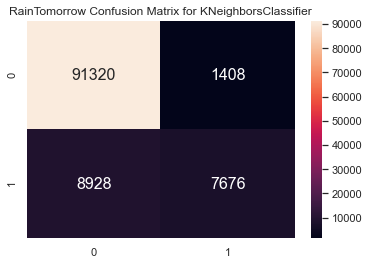

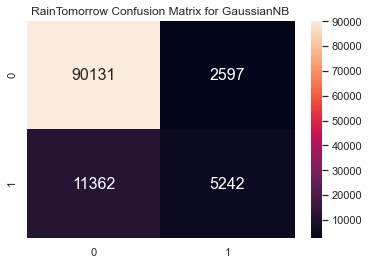

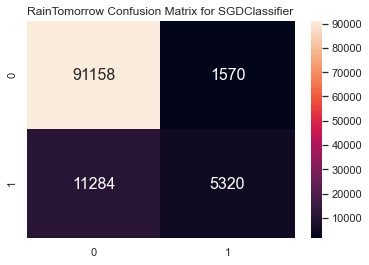

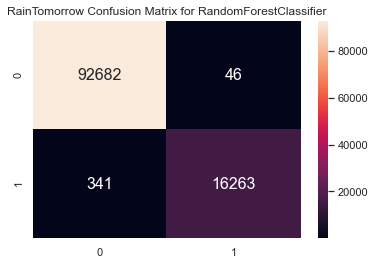

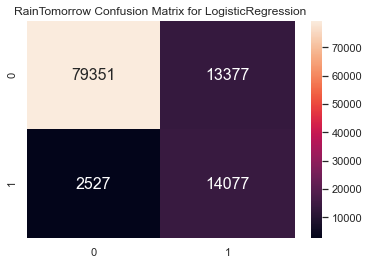

In [72]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

for key in model_stats_raintomorrow:
    conf_data = model_stats_raintomorrow[key][3]

    df_cm = pd.DataFrame(conf_data, range(2), range(2))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
    plt.title("RainTomorrow Confusion Matrix for " + key)
    plt.show()


#Reference: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

We printed the confusion matrix for all our classification models.Due to imbalanced data most of the observations 
fall for "No" `RainTomorrow`. And we see all models doing a good prediction on the True Negative.

`RandomForest` is giving the best accuracy but as we know it is suseptible to overfitting as well. 

We will evaluate more in classification report below.

#### Classification Report

As discussed earlier we are printing the classification report to check the `Macro Average` and `Weighted Average` values for `Precision`,`Recall` and `f1-score`.

In [73]:
for key in model_stats_raintomorrow:
    print("RainTomorrow Classification Report for " + key + "\n")
    print(model_stats_raintomorrow[key][6])
    print("\n\n\n\n")


RainTomorrow Classification Report for KNeighborsClassifier

              precision    recall  f1-score   support

          No       0.91      0.98      0.95     92728
         Yes       0.85      0.46      0.60     16604

    accuracy                           0.91    109332
   macro avg       0.88      0.72      0.77    109332
weighted avg       0.90      0.91      0.89    109332






RainTomorrow Classification Report for GaussianNB

              precision    recall  f1-score   support

          No       0.89      0.97      0.93     92728
         Yes       0.67      0.32      0.43     16604

    accuracy                           0.87    109332
   macro avg       0.78      0.64      0.68    109332
weighted avg       0.85      0.87      0.85    109332






RainTomorrow Classification Report for SGDClassifier

              precision    recall  f1-score   support

          No       0.89      0.98      0.93     92728
         Yes       0.77      0.32      0.45     16604

    ac

Based on the above statistics we can conclude that `Random Forest` and `KNN` are the best model for our dataset. Both model have good statistics in terms of `recall`, `precision`, and `f1 score`. Macro average and weighted average for both `Random Forest` and `KNN` are very close which is an indication of good model.   

### RainfallAmount Statistics

#### ROC Curves

Multiple Class ROC curves arent supported by SKLearn. So, for `RainfallAmount` those visualizations cannot be presented.

#### Confusion Matrix

We printed the confusion matrix for `RainfallAmount`. We observe all models doing a good prediction on the True Negative.

`RandomForest` is giving the best accuracy but as we know it is suseptible to overfitting as well.

`Naive Bayes` does a good job in predicting the data with high TP and TN and low FP.

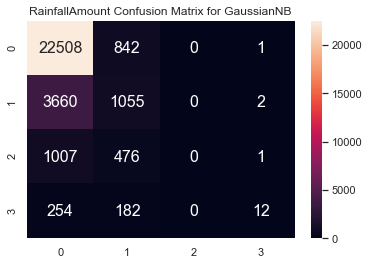

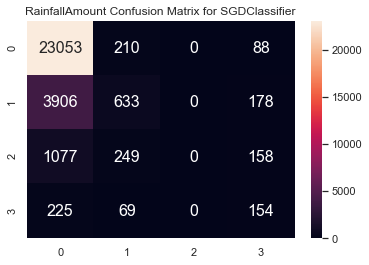

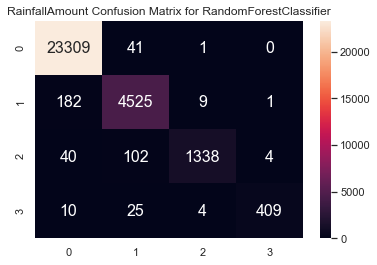

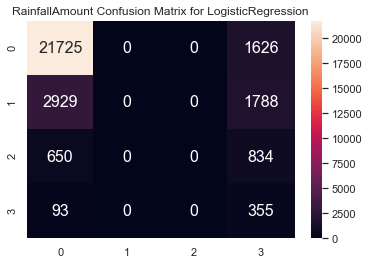

In [74]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

for key in model_stats_rainfallamount:
    conf_data = model_stats_rainfallamount[key][3]

    df_cm = pd.DataFrame(conf_data, range(4), range(4))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
    plt.title("RainfallAmount Confusion Matrix for " + key)
    plt.show()
    

#Reference: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

Given above confusion matrix plots, `Rainfom Forest` predicts better `RainfallAmount`.

#### Classification Report

Classification Report for multiple classes aren't supported. So, for `RainfallAmount` those visualizations cannot be presented.


## Modeling And Evaluation 5

As discussed in above sections we notice that `Naive Bayes` and `Random Forest` stands out for classification.

Below we will discuss the statistical significance of different models.

### Statistical comparison of Models

### Pairwise Comparison

There are several Pairwise Comparison tests that can be performed to compare the various models and their output being significantly different from each other. When we have more than two groups, it is inappropriate to simply compare each pair using a t-test because of the problem of multiple testing. The correct way to do the analysis is to use a one-way analysis of variance (`ANOVA`) to evaluate whether there is any evidence that the means of the populations differ. If the ANOVA leads to a conclusion that there is evidence that the group means differ, we might then be interested in investigating which of the means are different. 
We ran three different comparison techniques:

    1. Tukey's
    2. BonFerroni
    3. Kruskal-Wallis
    
`Tukey’s`: Tukey's multiple comparison test is also called Tukey's honestly significant difference test `Tukey's HSD`. The test compares the difference between each pair of means with appropriate adjustment for the multiple testing. The results are presented as a matrix showing the result for each pair as a P-value. The Tukey multiple comparison test, like both the t-test and ANOVA, assumes that the data from the different groups come from populations where the observations have a normal distribution and the standard deviation is the same for each group.

###### Reference : http://www.blackwellpublishing.com/specialarticles/jcn_8_304.pdf


`Bonferroni`: Bonferroni's method provides a pairwise comparison of the means. To determine which means are significantly different, we must compare all pairs. To counter higher error rate, the Bonferroni method adjusts the confidence level for each individual interval so that the resulting simultaneous confidence level is equal to the value specified.

###### Reference: https://www.spcforexcel.com/knowledge/comparing-processes/bonferronis-method



`Kruskal-Wallis` : The Kruskal–Wallis test is a nonparametric approach to the one-way ANOVA. The procedure is used to compare three or more groups on a dependent variable that is measured on at least an ordinal level.
The null hypothesis of the Kruskal-Wallis test is that the mean ranks of the groups are the same. As the nonparametric equivalent one-way ANOVA, Kruskal-Wallis test is called one-way ANOVA on ranks. Unlike the analogous one-way ANOVA, the nonparametric Kruskal-Wallis test does not assume a normal distribution of the underlying data.

###### Reference: https://www.sciencedirect.com/topics/medicine-and-dentistry/kruskal-wallis-test



### RainTomorrow

In [75]:
from scipy.stats import f_oneway
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi
from scipy import stats


GaussianNB_stat = model_stats_raintomorrow['GaussianNB'][1].tolist()
SGDClassifier_stat = model_stats_raintomorrow['SGDClassifier'][1].tolist()
RandomForestClassifier_stat = model_stats_raintomorrow['RandomForestClassifier'][1].tolist()
LogisticRegression_stat = model_stats_raintomorrow['LogisticRegression'][1].tolist()
KNeighborsClassifier_stat = model_stats_raintomorrow['KNeighborsClassifier'][1].tolist()


    
anova_result = f_oneway(GaussianNB_stat, SGDClassifier_stat, RandomForestClassifier_stat, LogisticRegression_stat,
                       KNeighborsClassifier_stat)

df_testscores_rt = pd.DataFrame({'score':GaussianNB_stat + SGDClassifier_stat +RandomForestClassifier_stat + LogisticRegression_stat+KNeighborsClassifier_stat,
                   'model': np.repeat(["GaussianNB", "SGDClassifier", "RandomForestClassifier","LogisticRegression","KNeighborsClassifier"], repeats=10)}) 

tukey = multi.pairwise_tukeyhsd(endog=df_testscores_rt['score'],
                          groups=df_testscores_rt['model'],
                          alpha=0.05)


multi_comp = multi.MultiComparison(df_testscores_rt['score'],
                          df_testscores_rt['model'],
                          )

tukey_2 = multi_comp.tukeyhsd(alpha=.05)
kruskal = multi_comp.kruskal()
allpair_holm = multi_comp.allpairtest(stats.ttest_rel, method='Holm', alpha=.05)
allpair_bonf = multi_comp.allpairtest(stats.ttest_rel, method='bonf', alpha=.05)

rank = multi_comp.getranks()

print (allpair_holm[0])
print (allpair_bonf[0])
print(tukey_2)
print(kruskal)



MultiComparison.kruskal
0 1 9.55 6.652302233061874 1.435593222529277 False
0.1511181244065383
Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.01, alphacBonf=0.005
        group1                 group2           stat   pval  pval_corr reject
-----------------------------------------------------------------------------
            GaussianNB   KNeighborsClassifier  -3.007 0.0148    0.0887  False
            GaussianNB     LogisticRegression  0.5297 0.6091       1.0  False
            GaussianNB RandomForestClassifier -8.4018    0.0    0.0001   True
            GaussianNB          SGDClassifier -0.4479 0.6648       1.0  False
  KNeighborsClassifier     LogisticRegression  2.2895 0.0478    0.1913  False
  KNeighborsClassifier RandomForestClassifier -9.2572    0.0    0.0001   True
  KNeighborsClassifier          SGDClassifier  2.8768 0.0183    0.0914  False
    LogisticRegression RandomForestClassifier -7.9378    0.0    0.0002   True
    LogisticRegression          S

Text(0.5, 1.0, 'Model Comparisons RainTomorrow for Accuracy')

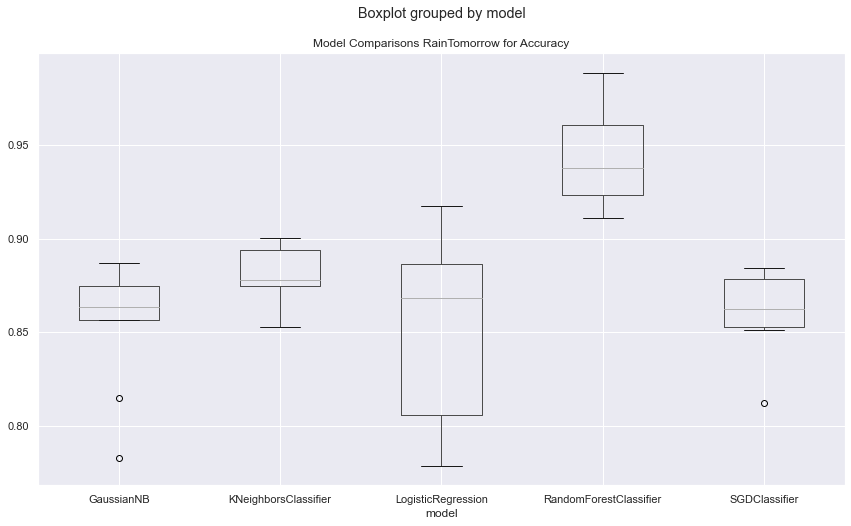

In [76]:
plt_t = df_testscores_rt.boxplot("score",by="model", showfliers=True, figsize= (14,8))

plt.title('Model Comparisons RainTomorrow for Accuracy')


Based on our earlier assertion that Random Forest is best in terms of accuracy and overall prediction like Precision and Recall.

We observe based on the statistical comparision as well that this model is different from all other models as we consistently reject the Null hypothesis that the models are same. In other words `Kruskal-Wallis`, `Bonferroni` and `Tukey's` multiple comparision strongly suggests the output from Random Forest is significantly different from other models.

#### RainfallAmount

In [79]:
from scipy.stats import f_oneway
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi
from scipy import stats


GaussianNB_stat = model_stats_rainfallamount['GaussianNB'][1].tolist()
SGDClassifier_stat = model_stats_rainfallamount['SGDClassifier'][1].tolist()
RandomForestClassifier_stat = model_stats_rainfallamount['RandomForestClassifier'][1].tolist()
LogisticRegression_stat = model_stats_rainfallamount['LogisticRegression'][1].tolist()



anova_result = f_oneway(GaussianNB_stat, SGDClassifier_stat, RandomForestClassifier_stat, 
                        LogisticRegression_stat)

df_testscores_ra = pd.DataFrame({'score':GaussianNB_stat + SGDClassifier_stat +RandomForestClassifier_stat + LogisticRegression_stat,
                   'model': np.repeat(["GaussianNB", "SGDClassifier", "RandomForestClassifier","LogisticRegression"], repeats=10)}) 


multi_comp = multi.MultiComparison(df_testscores_ra['score'],
                          df_testscores_ra['model'],
                          )

tukey_2 = multi_comp.tukeyhsd(alpha=.05)
kruskal = multi_comp.kruskal()
allpair_holm = multi_comp.allpairtest(stats.ttest_rel, method='Holm', alpha=.05)
allpair_bonf = multi_comp.allpairtest(stats.ttest_rel, method='bonf', alpha=.05)

rank = multi_comp.getranks()

print (allpair_holm[0])
print (allpair_bonf[0])
print(tukey_2)
print(kruskal)


MultiComparison.kruskal
0 1 13.100000000000001 5.397900826555943 2.4268693369748844 False
0.01522973979770801
Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.01, alphacBonf=0.008
        group1                 group2           stat    pval  pval_corr reject
------------------------------------------------------------------------------
            GaussianNB     LogisticRegression   4.0686 0.0028    0.0084   True
            GaussianNB RandomForestClassifier -50.3667    0.0       0.0   True
            GaussianNB          SGDClassifier   1.5687 0.1512    0.2979  False
    LogisticRegression RandomForestClassifier  -7.0574 0.0001    0.0003   True
    LogisticRegression          SGDClassifier  -1.5784 0.1489    0.2979  False
RandomForestClassifier          SGDClassifier    4.315 0.0019    0.0078   True
------------------------------------------------------------------------------
Test Multiple Comparison ttest_rel 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf

Text(0.5, 1.0, 'Model Comparisons RainfallAmount for Accuracy')

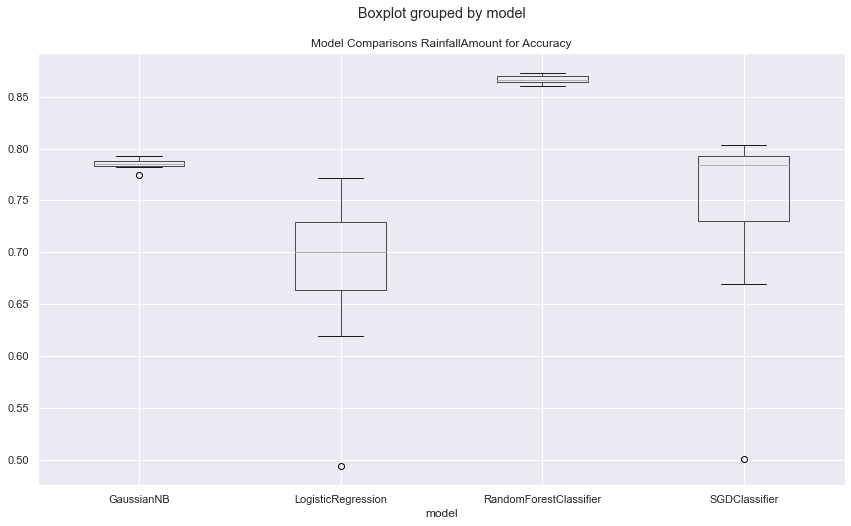

In [80]:
df_testscores_ra.boxplot("score",by="model", showfliers=True, figsize= (14,8))
plt.title('Model Comparisons RainfallAmount for Accuracy')


Based on our earlier assertion that Naive Bayes and Random Forest are best in terms of accuracy and overall prediction like Precision and Recall for RainfallAmount.

We observe based on the statistical comparision as well that these two models are different from all other models as we consistently reject the Null hypothesis that the models are same. In other words `Kruskal-Wallis`, `Bonferroni` and `Tukey's` multiple comparision strongly suggests the output from Naive Bayes and Random Forest is significantly different from other models.

#### Rainfall (Linear)

In [81]:
from scipy.stats import f_oneway
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as multi
from scipy import stats


Linear_stat = model_stats_rainfall['LinearRegression'][0]["test_score"].tolist()
Lasso_stat = model_stats_rainfall['Lasso'][0]["test_score"].tolist()
Elasticnet_stat = model_stats_rainfall['ElasticNet'][0]["test_score"].tolist()


#Convert them in abs value, as sklearn gives them in negative (but the values are not really negative)

Linear_stat =[abs(number) for number in Linear_stat]
Lasso_stat = [abs(number) for number in Lasso_stat]
Elasticnet_stat = [abs(number) for number in Elasticnet_stat]


all_stats = Linear_stat + Lasso_stat + Elasticnet_stat  
    
anova_result = f_oneway(Linear_stat, Lasso_stat, Elasticnet_stat)

df_testscores_r = pd.DataFrame({'score':all_stats,
                   'model': np.repeat(["LinearRegression", "LASSO", "ElasticNet"], repeats=10)}) 

tukey = multi.pairwise_tukeyhsd(endog=df_testscores_r['score'],
                          groups=df_testscores_r['model'],
                          alpha=0.05)


multi_comp = multi.MultiComparison(df_testscores_r['score'],
                          df_testscores_r['model'],
                          )

tukey_2 = multi_comp.tukeyhsd(alpha=.05)
kruskal = multi_comp.kruskal()
allpair_holm = multi_comp.allpairtest(stats.ttest_rel, method='Holm', alpha=.05)
allpair_bonf = multi_comp.allpairtest(stats.ttest_rel, method='bonf', alpha=.05)

rank = multi_comp.getranks()

print (allpair_holm[0])
print (allpair_bonf[0])
print(tukey_2)
print(kruskal)


MultiComparison.kruskal
0 1 1.9999999999999982 4.17350272552924 0.47921377594077863 False
0.6317865549340709
Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.02, alphacBonf=0.017
  group1        group2       stat   pval  pval_corr reject
----------------------------------------------------------
ElasticNet            LASSO 5.0451 0.0007    0.0021   True
ElasticNet LinearRegression 4.8027  0.001    0.0021   True
     LASSO LinearRegression 4.1408 0.0025    0.0025   True
----------------------------------------------------------
Test Multiple Comparison ttest_rel 
FWER=0.05 method=bonf
alphacSidak=0.02, alphacBonf=0.017
  group1        group2       stat   pval  pval_corr reject
----------------------------------------------------------
ElasticNet            LASSO 5.0451 0.0007    0.0021   True
ElasticNet LinearRegression 4.8027  0.001    0.0029   True
     LASSO LinearRegression 4.1408 0.0025    0.0076   True
--------------------------------------------------------

Text(0.5, 1.0, 'Model Comparisons Rainfall for RMSE')

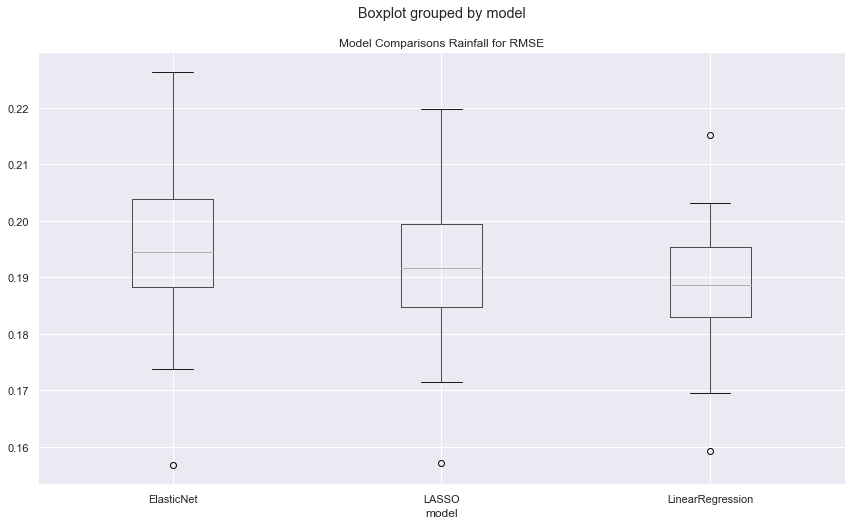

In [82]:

df_testscores_r.boxplot("score",by="model", showfliers=True, figsize= (14,8))
plt.title('Model Comparisons Rainfall for RMSE')

#Plot references
# http://www.r-graph-gallery.com/84-tukey-test


`ElasticNet` and `Lasso` are better than Linear regression model for `Rainfall`. The RMSE is better for `Lasso`compared to other two models.

We observe based on the statistical comparision as well that `Lasso` model is different from other models as we consistently reject the Null hypothesis that the models are same. In other words `Bonferroni` and `Tukey's` multiple comparision strongly suggests the output from `Lasso` is significantly different from other models.

## Modeling And Evaluation 6

Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


In [83]:
import time
import numpy as np

start_time = time.time()

clf = model_stats_rainfallamount['RandomForestClassifier'][0].best_estimator_
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.040 seconds


In [84]:
column_names_rt = df_model_copy.columns
column_names_rt = column_names_rt.drop('RainfallAmount')
column_names_rt = column_names_rt.drop('RainTomorrow')
print(column_names_rt)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'IsRainToday', 'GustDir_ENE', 'GustDir_ESE',
       'GustDir_N', 'GustDir_NE', 'GustDir_NNE', 'GustDir_NNW', 'GustDir_NW',
       'GustDir_S', 'GustDir_SE', 'GustDir_SSE', 'GustDir_SSW', 'GustDir_SW',
       'GustDir_W', 'GustDir_WNW', 'GustDir_WSW', 'Wind3pm_ENE', 'Wind3pm_ESE',
       'Wind3pm_N', 'Wind3pm_NE', 'Wind3pm_NNE', 'Wind3pm_NNW', 'Wind3pm_NW',
       'Wind3pm_S', 'Wind3pm_SE', 'Wind3pm_SSE', 'Wind3pm_SSW', 'Wind3pm_SW',
       'Wind3pm_W', 'Wind3pm_WNW', 'Wind3pm_WSW', 'Wind9am_ENE', 'Wind9am_ESE',
       'Wind9am_N', 'Wind9am_NE', 'Wind9am_NNE', 'Wind9am_NNW', 'Wind9am_NW',
       'Wind9am_S', 'Wind9am_SE', 'Wind9am_SSE', 'Wind9am_SSW', 'Wind9am_SW',
       'Wind9am_W', 'Wind9am_WNW', 'Wind9am_WSW'],
      dtype='object')


Elapsed time to compute the importances: 378.633 seconds


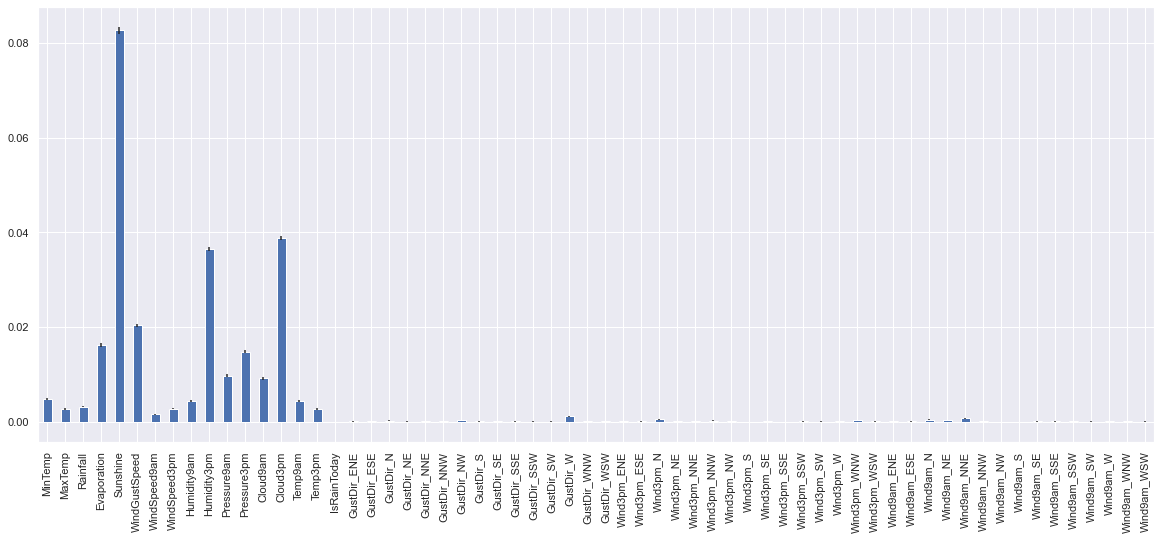

In [85]:
#Attribute Importance - Random Forest Model (RainTomorrow Classification)

from sklearn.inspection import permutation_importance
clf = model_stats_raintomorrow['RandomForestClassifier'][0].best_estimator_
start_time = time.time()


df_model = df_model_copy.copy()

y = df_model["RainTomorrow"].values


if "RainfallAmount" in df_model:
    del df_model["RainfallAmount"]

if "RainTomorrow" in df_model:
    del df_model["RainTomorrow"]

X = df_model.values
column_names_rt = df_model.columns
    
result = permutation_importance(
    clf, X, y, n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=column_names_rt)


plt.figure(figsize=(20,8))
forest_importances.plot.bar(yerr=result.importances_std)

plt.show()


The above plot depicts the weights of the features from the top logistic regression model.

As we can see some features have much higher weight then the others. As per the model following features are of high importance:

Important feeature:

`Coud3pm` - The clouds at 3pm (afternoon) has high importance in predicting the chances of `RainTomorrow`. This is expected as clouds in the afternoon is expected for the rains the next day.

`Pressure9am` - The pressure in the morning is negatively correlated to pressure in the afternoon in terms of predicting the `RainTomorrow`. If the Pressure is high in the morning this increases the chance of Rain the next day as by the afternoon we may observe the change in pressure.

`Humidity3pm` - As expected the higher humidity in afternoon has higher predictability for `RainTomorrow`.

`WindGustSpeed` - The increase in `WindGustSpeed` has positive impact on the prediction for `RainTomorrow`. Which meets the expectation as the Pressure reduces we may see higher Wind Gusts and may lead to Rains the next day.

`Sunshine` - More sunshine leads to lower chances on `RainTomorrow`. This makes sense as this means the cloud cover is less and chances are rain reduces significantly.

`Pressure3pm` - Lower pressure in the afternoon leads to higher chances of `RainTomorrow`. This is also expected as the pressure towards the later part of day will have impact on the rain the next day.

`MinTemp` - Albeit smaller but the increase in `MinTemp` reduces the chances of `RainTomorrow`. This is in line with the `Sunshine`, as more sunshine will increase the minimum temperature and the chances or Rain will reduce.

Surprisingly `RainToday` doesn’t have higher weight and is not among the most important features. One would assume that based on the fact if it rained today the chances of `RainTomorrow` may significantly increase.

Elapsed time to compute the importances: 338.562 seconds


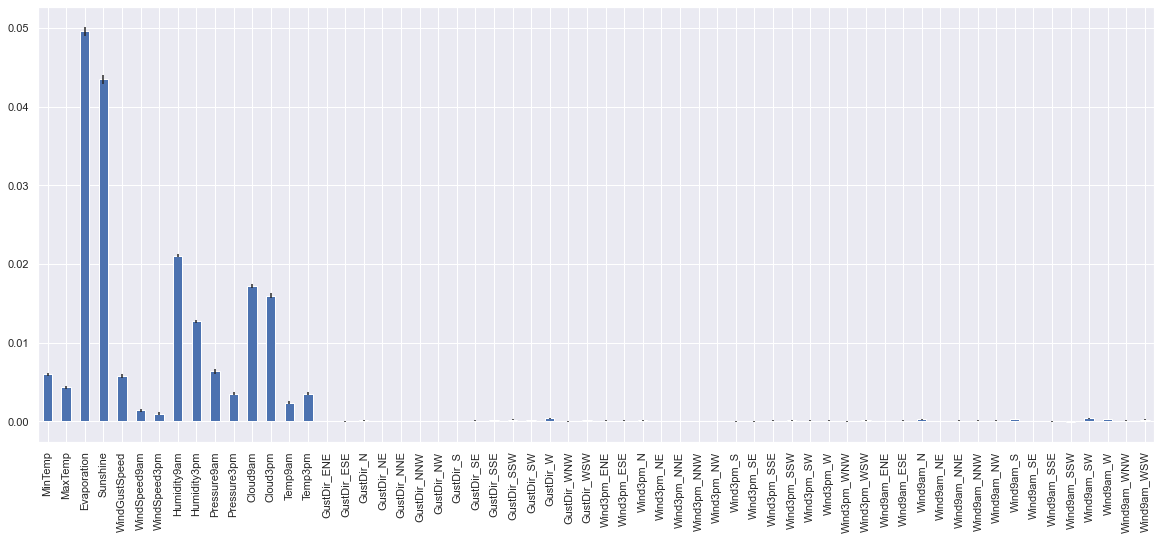

In [86]:
#Attribute Importance - Random Forest Model ('RainfallAmount')

from sklearn.inspection import permutation_importance
start_time = time.time()

clf = model_stats_rainfallamount['RandomForestClassifier'][0].best_estimator_
start_time = time.time()


df_model = df_model_copy.copy()

y2 = df_model["RainfallAmount"].values


if "RainfallAmount" in df_model:
    del df_model["RainfallAmount"]

if "RainTomorrow" in df_model:
    del df_model["RainTomorrow"]

if "IsRainToday" in df_model:
    del df_model["IsRainToday"]
    
if "Rainfall" in df_model:
    del df_model["Rainfall"]
   

X2 = df_model.values
column_names_ra = df_model.columns



result = permutation_importance(
    clf, X2, y2, n_repeats=10, random_state=123, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances2 = pd.Series(result.importances_mean, index=column_names_ra)

#Visuals RainfallAmount Attribute importance
plt.figure(figsize=(20,8))
forest_importances2.plot.bar(yerr=result.importances_std)

plt.show()


## Deployment

Our models are primarily designed for meteorologists. At the same time, these can be very useful for event organizers in cities across the country – mostly important for outdoor events. The favored model can be also useful for government organizations like military (Navy). The model not only predicts if it’s going to Rain Tomorrow (next day), It also predicts the amount of `Rainfall` for today in amount of rain fell (mm) as well as classifies as `Low`, `Medium` and `High`. Due to our ability to give the data which is easily interpretable for everyone, this is useful for the everyone. It can be integrated by the weather channels and apps as well. 


The model’s value can be measured in terms of its accuracy; higher the accuracy better the value of the model over existing models in use. Some parties may value our models higher than others depending upon how important the accuracy of prediction of Rainfall for their business or area of operations.


Our models can be integrated to the existing feed of weather related data which is useful for our model to predict accurately. This data is easily available from government websites. 


Data from those sources can be integrated with our model and build an APIs for anyone to consume and monetize by the count of API calls.


As we know weather is an ever-changing event and due to climate change, predictive models needs to evolve continuously. The validity of our models need to be tested against the recorded information and improve our models daily with the new data (models can be built within hours).


Additional data points may be required like seasons, time of the year, impact of natural events like cyclones/hurricanes, wild fires, El Niño and La Niña effects etc.


Overall, our classification models will be more useful since those clearly indicates weather condition for all the interested parties.

## Exceptional Work

##### Response Variables:

We did total of 3 response variables instead of 2 as per requirements.

1. `RainTomorrow` - Categorical variable for classification
2. `Rainfall` - Continuous variable for regression
3. `RainfallAmount` - Categorical variable for rainfall classification.

##### Models:

We did 5 models each for classification variable.

1. KNN
2. Naive Bayes
3. Logistic Regression
4. SGDClassifier
5. Random Forest

##### Statistical comparision

We did 3 statistical comparisions:

1. Tukeys
2. Bonferroni
3. Kruskal-Wallis

#### Conclusion




For our dataset we noticed that classification models perform better than regression models and have higher accuracy.